In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from wrf_helpers import get_zgrid_meanProfiles as zgrid
from pandas import to_datetime
from scipy.integrate import quad

In [2]:
save=True
savename='profiles_WRFvsFluxPrandtl'

In [3]:
T0 = -5 # K
slope = 3*np.pi/180. # rad
Tref = 308 # K
lapse = 0.015 # K/m
Km = 0.015 # m^2 / s
Kh = 0.02 # m^2 / s
Pr = 0.75
assert Km == Pr*Kh
hfx = -0.008 # K m/s
Pr_sfc = 2
g = 9.8 # m / s^2

In [4]:
path = "../WRFV3/LES3"
file= "wrfout_d01_2014-03-21_12:00:00"

ds = xr.open_dataset(path+'/'+file)#+'.nc')
ds

<xarray.Dataset>
Dimensions:                (Time: 121, south_north: 149, west_east: 399,
                            bottom_top: 68, bottom_top_stag: 69,
                            soil_layers_stag: 4, west_east_stag: 400,
                            south_north_stag: 150)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag
Data variables: (12/153)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/119)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2014-03-21_12:00:00
    SIMULATION_START_DATE:           2014-03-21_12:00:00
    WEST-EAST_GRID_DIMENSION:        400
    SOUTH-NORTH_GRID_DIMENSION:      150
    BOTTOM-TOP_GRID_DIMENSION:       69
    ...                              ...
    ISLAKE:                          0
    ISICE:                           0
    ISURBAN:                         0
    ISOILWATER:                      0
    HYBRID_OPT:                      -1
    ETAC:                            0.0

In [5]:
time = b'2014-03-22_04:20:00'
itime = ds['Times'].values.tolist().index(time)
timeStr = time.decode('utf-8')
time = to_datetime(timeStr, format='%Y-%m-%d_%H:%M:%S')

In [6]:
nx = ds.sizes['west_east_stag']
dx = ds.attrs['DX']
xmid = (nx-1)/2*dx
xplot = 9975 + 1000 + 1525
xuv = np.arange(0,nx*dx,dx)
xcv = np.arange(dx/2,nx*dx-dx/2,dx)
ix = np.where(xuv == xplot)[0][0]

In [7]:
ztop = 50 # [m a.s.l.]
ktop = 12 # just for speed, make sure higher than ztop everywhere

timelabel=time.strftime('%H:%M')
loclabel=str(int(xplot-xmid))

zc, zu = zgrid(ds, itime, ktop, ix)

u_wrf = ds['U'][itime,:ktop,:,ix].mean(dim="south_north")
T_wrf = ds['T'][itime,:ktop,:,ix-1:ix+1].mean(dim="south_north") + 300 - Tref - lapse*zc

In [8]:
n = np.linspace(0,ztop,100)

## Pr from mean WRF , K from mean WRF ##

In [9]:
mu = ( g / (Tref*lapse*Pr) )**0.5
sigma0 = ( g*lapse*np.sin(slope)**2 / (Tref*Pr) )**0.5
sigma = ( g*lapse*np.sin(slope)**2 / (4*Tref*Km*Kh) )**0.25

In [10]:
def Kh_GO(n, h = 20, C = 0.008):
    return C * n * np.exp( -0.5 * n**2 / h**2 ) 

def integrand_GO(n):
    return Kh_GO(n)**-0.5

def integral_GO(z):
    integral, _ = quad(integrand_GO, 0, z)
    return integral

In [11]:
exp_arg = np.zeros( n.shape )
exp_arg[1:] = np.array([ (sigma0/2)**0.5 * integral_GO(nk) for nk in n[1:] ])

In [12]:
u_Prandtl = -T0 * mu*np.exp(-sigma*n)*np.sin(sigma*n)
u_flux = -hfx/sigma/Kh * mu*np.exp(-sigma*n)*np.sin(sigma*n)

T_Prandtl = T0 * np.exp(-sigma*n)*np.cos(sigma*n)
T_flux = hfx/sigma/Kh * np.exp(-sigma*n)*np.cos(sigma*n)

In [13]:
u_GO = -T0 *  mu*np.exp(-1*exp_arg)*np.sin(exp_arg)
u_fluxGO = -hfx/sigma/Kh * mu*np.exp(-1*exp_arg)*np.sin(exp_arg)

T_GO = T0 * np.exp(-1*exp_arg)*np.cos(exp_arg)
T_fluxGO = hfx/sigma/Kh * np.exp(-1*exp_arg)*np.cos(exp_arg)

## Pr from mean WRF , K from Surface ##

In [14]:
Kh0 = (hfx/T0)**2 * 2 / sigma0
print('Kh Effective: '+str(Kh0))
Km0 = Pr * Kh0
sigma = ( g*lapse*np.sin(slope)**2 / (4*Tref*Km0*Kh0) )**0.25
# mu = ( g / (Tref*lapse*Pr) )**0.5
# sigma0 = ( g*lapse*np.sin(slope)**2 / (Tref*Pr) )**0.5

Kh Effective: 0.0038780831796384712


In [15]:
def Kh_effGO( n, h = 20, C = 0.008, frac = 0.5, Kh0 = 0.004005267085319175):

    return Kh0 + frac * C * n * np.exp( -0.5 * n**2 / h**2 ) 

def integrand_effGO(n):
    return Kh_effGO(n)**-0.5

def integral_effGO(z):
    integral, _ = quad(integrand_effGO, 0, z)
    return integral

In [16]:
exp_arg = np.zeros( n.shape )
exp_arg[1:] = np.array([ (sigma0/2)**0.5 * integral_effGO(nk) for nk in n[1:] ])

In [17]:
u_Prandtl_K0 = -T0 * mu*np.exp(-sigma*n)*np.sin(sigma*n)
u_flux_K0 = -hfx/sigma/Kh0 * mu*np.exp(-sigma*n)*np.sin(sigma*n)

T_Prandtl_K0 = T0 * np.exp(-sigma*n)*np.cos(sigma*n)
T_flux_K0 = hfx/sigma/Kh0 * np.exp(-sigma*n)*np.cos(sigma*n)

In [18]:
u_GO_K0 = -T0 *  mu*np.exp(-1*exp_arg)*np.sin(exp_arg)
u_fluxGO_K0 = -hfx/sigma/Kh0 * mu*np.exp(-1*exp_arg)*np.sin(exp_arg)

T_GO_K0 = T0 * np.exp(-1*exp_arg)*np.cos(exp_arg)
T_fluxGO_K0 = hfx/sigma/Kh0 * np.exp(-1*exp_arg)*np.cos(exp_arg)

## Pr from Surface, K from Surface ##

In [19]:
Pr = Pr_sfc
mu = ( g / (Tref*lapse*Pr) )**0.5
sigma0 = ( g*lapse*np.sin(slope)**2 / (Tref*Pr) )**0.5
Kh0 = (hfx/T0)**2 * 2 / sigma0
print('Kh Effective: '+str(Kh0))
Km0 = Pr * Kh0
sigma = ( g*lapse*np.sin(slope)**2 / (4*Tref*Km0*Kh0) )**0.25

Kh Effective: 0.006332883313456273


In [20]:
def Kh_effGO( n, h = 20, C = 0.008, frac = 0.5, Kh0 = 0.006332883313456273):

    return Kh0 + frac * C * n * np.exp( -0.5 * n**2 / h**2 ) 

def integrand_effGO(n):
    return Kh_effGO(n)**-0.5

def integral_fluxGO(z):
    integral, _ = quad(integrand_effGO, 0, z)
    return integral

In [21]:
exp_arg = np.zeros( n.shape )
exp_arg[1:] = np.array([ (sigma0/2)**0.5 * integral_effGO(nk) for nk in n[1:] ])

In [22]:
u_Prandtl_K0_PrSfc = -T0 * mu*np.exp(-sigma*n)*np.sin(sigma*n)
u_flux_K0_PrSfc = -hfx/sigma/Kh0* mu*np.exp(-sigma*n)*np.sin(sigma*n)

T_Prandtl_K0_PrSfc = T0 * np.exp(-sigma*n)*np.cos(sigma*n)
T_flux_K0_PrSfc = hfx/sigma/Kh0 * np.exp(-sigma*n)*np.cos(sigma*n)

In [23]:
u_GO_K0_PrSfc = -T0 *  mu*np.exp(-1*exp_arg)*np.sin(exp_arg)
u_fluxGO_K0_PrSfc = -hfx/sigma/Kh0 * mu*np.exp(-1*exp_arg)*np.sin(exp_arg)

T_GO_K0_PrSfc = T0 * np.exp(-1*exp_arg)*np.cos(exp_arg)
T_fluxGO_K0_PrSfc = hfx/sigma/Kh0 * np.exp(-1*exp_arg)*np.cos(exp_arg)

## Pr from surface, K from mean WRF ##

In [24]:
# mu = ( g / (Tref*lapse*Pr) )**0.5
# sigma0 = ( g*lapse*np.sin(slope)**2 / (Tref*Pr) )**0.5
sigma = ( g*lapse*np.sin(slope)**2 / (4*Tref*Km*Kh) )**0.25

In [25]:
exp_arg = np.zeros( n.shape )
exp_arg[1:] = np.array([ (sigma0/2)**0.5 * integral_GO(nk) for nk in n[1:] ])

In [26]:
u_Prandtl_PrSfc = -T0 * mu*np.exp(-sigma*n)*np.sin(sigma*n)
u_flux_PrSfc = -hfx/sigma/Kh * mu*np.exp(-sigma*n)*np.sin(sigma*n)

T_Prandtl_PrSfc = T0 * np.exp(-sigma*n)*np.cos(sigma*n)
T_flux_PrSfc = hfx/sigma/Kh * np.exp(-sigma*n)*np.cos(sigma*n)

In [27]:
u_GO_PrSfc = -T0 *  mu*np.exp(-1*exp_arg)*np.sin(exp_arg)
u_fluxGO_PrSfc = -hfx/sigma/Kh * mu*np.exp(-1*exp_arg)*np.sin(exp_arg)

T_GO_PrSfc = T0 * np.exp(-1*exp_arg)*np.cos(exp_arg)
T_fluxGO_PrSfc = hfx/sigma/Kh * np.exp(-1*exp_arg)*np.cos(exp_arg)

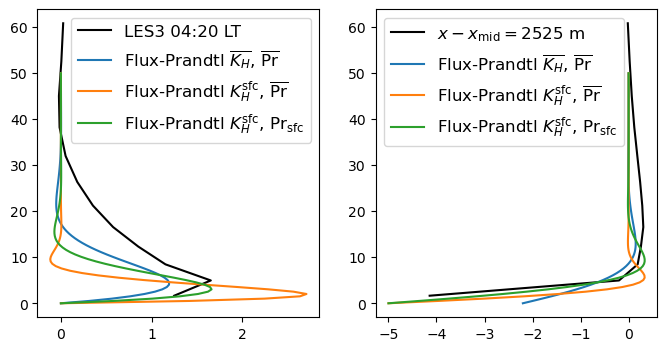

In [28]:
try:
    del(fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots( 1, 2, figsize=(8, 4) )
except:
    fig, axs = plt.subplots( 1, 2, figsize=(8, 4) )

axs[0].plot(u_wrf,zu,'k', label=path[-4:]+' '+timelabel+' LT')
    # axs[1].plot(T_wrf[:,0],zc[:,0]) # slightly uphill
axs[1].plot(T_wrf.mean(axis=1),zc.mean(axis=1), 'k',
            label=r'$x-x_{\text{mid}}=$'+loclabel+' m')
    # axs[1].plot(T_wrf[:,1],zc[:,1]) # slightly downhill


# axs[0].plot( u_Prandtl, n, label = r'Prandtl $\overline{K_H}$, $\overline{\text{Pr}}$' )
# axs[1].plot( T_Prandtl, n, label = r'Prandtl $\overline{K_H}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_GO, n, label = r'GO $\overline{K_H}$, $\overline{\text{Pr}}$')
# axs[1].plot( T_GO, n, label = r'GO $\overline{K_H}$, $\overline{\text{Pr}}$')

axs[0].plot( u_flux, n, label = r'Flux-Prandtl $\overline{K_H}$, $\overline{\text{Pr}}$')
axs[1].plot( T_flux, n, label = r'Flux-Prandtl $\overline{K_H}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_fluxGO, n, label = r'Flux-GO $\overline{K_H}$, $\overline{\text{Pr}}$')
# axs[1].plot( T_fluxGO, n, label = r'Flux-GO $\overline{K_H}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_Prandtl_K0, n, label = r'Prandtl $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$' )
# axs[1].plot( T_Prandtl_K0, n, label = r'Prandtl $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_GO_K0, n, label = r'GO $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$')
# axs[1].plot( T_GO_K0, n, label = r'GO $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$')

axs[0].plot( u_flux_K0, n, label = r'Flux-Prandtl $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$')
axs[1].plot( T_flux_K0, n, label = r'Flux-Prandtl $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_fluxGO_K0, n, label = r'Flux-GO $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$')
# axs[1].plot( T_fluxGO_K0, n, label = r'Flux-GO $K_H^{\text{sfc}}$, $\overline{\text{Pr}}$' )

# axs[0].plot( u_Prandtl_K0_PrSfc, n, label = r'Prandtl $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$' )
# axs[1].plot( T_Prandtl_K0_PrSfc, n, label = r'Prandtl $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$' )

# axs[0].plot( u_GO_K0_PrSfc, n, label = r'GO $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$')
# axs[1].plot( T_GO_K0_PrSfc, n, label = r'GO $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$')

axs[0].plot( u_flux_K0_PrSfc, n, label = r'Flux-Prandtl $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$')
axs[1].plot( T_flux_K0_PrSfc, n, label = r'Flux-Prandtl $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$' )

# axs[0].plot( u_fluxGO_K0_PrSfc, n, label = r'Flux-GO $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$')
# axs[1].plot( T_fluxGO_K0_PrSfc, n, label = r'Flux-GO $K_H^{\text{sfc}}$, Pr$_{\text{sfc}}$' )

# axs[0].plot( u_Prandtl_PrSfc, n, label = r'Prandtl $\overline{K_H}$, Pr$_{\text{sfc}}$' )
# axs[1].plot( T_Prandtl_PrSfc, n, label = r'Prandtl $\overline{K_H}$, Pr$_{\text{sfc}}$' )

# axs[0].plot( u_GO_PrSfc, n, label = r'GO $\overline{K_H}$, Pr$_{\text{sfc}}$')
# axs[1].plot( T_GO_PrSfc, n, label = r'GO $\overline{K_H}$, Pr$_{\text{sfc}}$')

# axs[0].plot( u_flux_PrSfc, n, label = r'Flux-Prandtl $\overline{K_H}$, Pr$_{\text{sfc}}$')
# axs[1].plot( T_flux_PrSfc, n, label = r'Flux-Prandtl $\overline{K_H}$, Pr$_{\text{sfc}}$' )

# axs[0].plot( u_fluxGO_PrSfc, n, label = r'Flux-GO $\overline{K_H}$, Pr$_{\text{sfc}}$')
# axs[1].plot( T_fluxGO_PrSfc, n, label = r'Flux-GO $\overline{K_H}$, Pr$_{\text{sfc}}$' )


axs[0].legend(fontsize=12)        
axs[1].legend(fontsize=12)

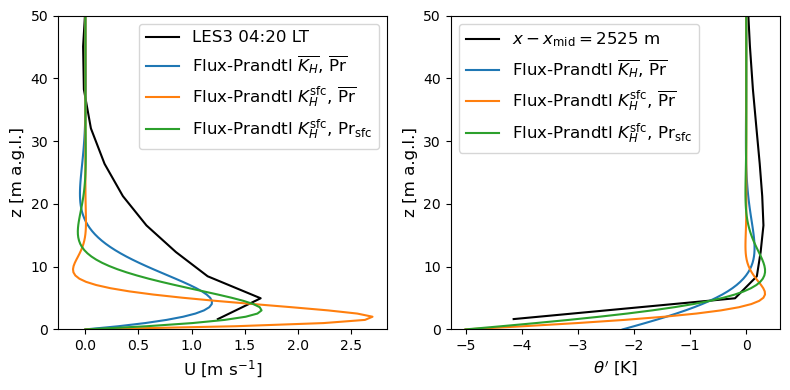

In [29]:
for ax in axs:
    ax.set_ylim( (0, ztop) )
axs[0].set_ylabel("z [m a.g.l.]",size=12)
axs[0].set_xlabel(r'U [m s$^{-1}$]',size=12)
axs[1].set_ylabel("z [m a.g.l.]",size=12)
axs[1].set_xlabel(r"$\theta'$ [K]",size=12) 
# axs[1].set_xlabel(r"$\theta$ [K]")  
fig.tight_layout() 
fig

In [30]:
# handles,labels=axs[0].get_legend_handles_labels()
# axs[0].legend(ncol=1,handles=handles[1:9:3],
#               labels=labels[1:9:3])
# handles,labels=axs[1].get_legend_handles_labels()
# axs[1].legend(ncol=1,handles=handles[3:6],
#               labels=labels[3:6])

In [31]:
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("plots/"+savename+"."+fmt, format=fmt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
